In [8]:
import numpy as np
from scipy.stats import norm

def tauchen(n, mu, rho, sigma):

    # n: number of grid points
    # mu: mean of the AR(1) process
    # rho: AR(1) coeffient
    # sigma: standard deviatin of the error term

    m = 1 / np.sqrt(1 - rho**2)

    # compute the state space
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)

    # compute the distance between grid points
    d = (state_space[n-1] - state_space[0]) / (n-1)

    # compute the transition probabilities
    transition_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if j==0:
                transition_matrix[i, 0] = norm.cdf((state_space[0] - rho*state_space[i] + d/2)/sigma)
            elif j==n-1:
                transition_matrix[i, n-1] = 1.0 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2)/sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho*state_space[i] + d/2)/sigma) - norm.cdf((state_space[j] - rho*state_space[i] - d/2)/sigma)

    return transition_matrix, state_space

In [9]:
# function to compile parameters into one thing "param"
def setPar(
    sigma = 1.5, # risk aversion
    beta = 0.98, # subject discount factor
    rho = 0.6, # labor productivity persistence
    sigma_eps = 0.6, # labor productivity std
    a_l = 0, # lower bound of asset grids
    a_u = 20, # upper bound of asset grids
    NA = 401, # number of grids of a
    NH = 2, # number of grids of h
    mu_h = -0.7, # mean of log h
    ):

    # # create a grid of asset holdings
    # a = np.linspace(a_l, a_u, NA)

    # making grids for ln h and solving for income transition probability using Tauchen's method
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)

    # create dictionary with parameters
    param = {}
    param['sigma'] = sigma
    param['beta'] = beta
    param['pi'] = pi
    param['h'] = h
    param['NA'] = NA
    param['NH'] = NH
    param['a_l'] = a_l
    param['a_u'] = a_u

    return param

In [10]:
def solve_household(param):
    # opening the box of param
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']

    # create a grid of asset holdings
    a = np.linspace(a_l, a_u, NA)

    # Initialize some variables
    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))

    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    util = np.full((NA, NA, NH), -10000.0)

    # calculate utility if the agent chooses asset a[iap] for (a[ia]), h[ih])
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w*h[ih] + (1.0 + r)*a[ia] - a[iap]
                if cons > 0: # count only if consumption is positive
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma) # set CRRA utility function

    # iterate on bellman's equation and get the decision rules and the value function
    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))

    while test > tol: # loop until value function converges
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])

        test = np.max(abs(v_new - v))
        v = v_new

    # asset policy function
    aplus = a[iaplus]

    # consumption policy function
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1.0+r)*a[ia] - aplus[ia, ih]

    return aplus, iaplus, c

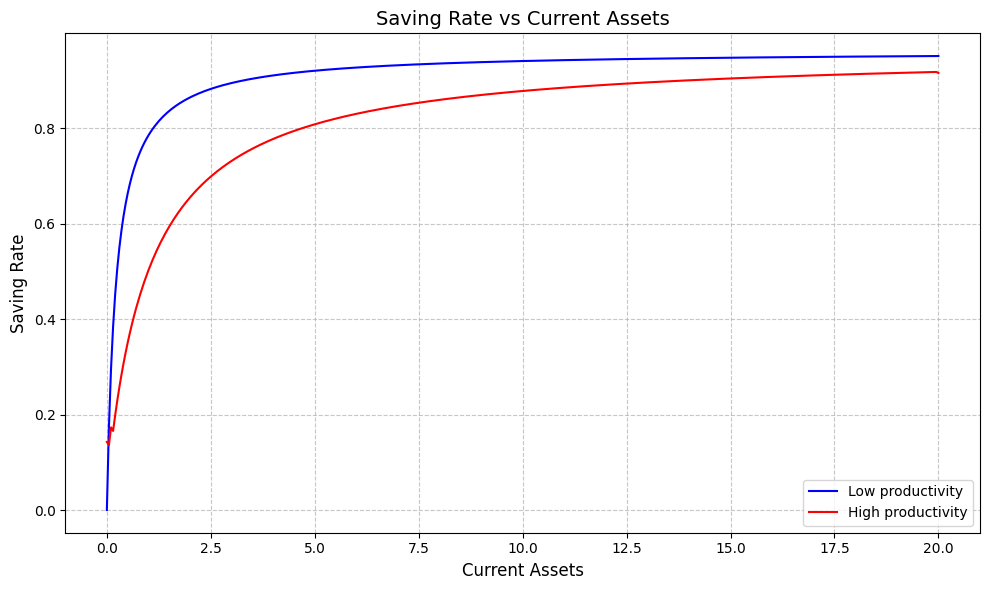

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# setting prices
r = 0.04  # interest rate
w = 1  # wage

# Get parameters and solve the household problem
param = setPar()
decisions = solve_household(param)
aplus = decisions[0]
c = decisions[2]

# Create asset grid
a_l = param['a_l']
a_u = param['a_u']
NA = param['NA']
a = np.linspace(a_l, a_u, NA)

# Calculate saving rates
saving_rate_low = aplus[:, 0] / (c[:, 0] + aplus[:, 0])
saving_rate_high = aplus[:, 1] / (c[:, 1] + aplus[:, 1])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(a, saving_rate_low, label='Low productivity', color='blue')
plt.plot(a, saving_rate_high, label='High productivity', color='red')

plt.xlabel('Current Assets', fontsize=12)
plt.ylabel('Saving Rate', fontsize=12)
plt.title('Saving Rate vs Current Assets', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

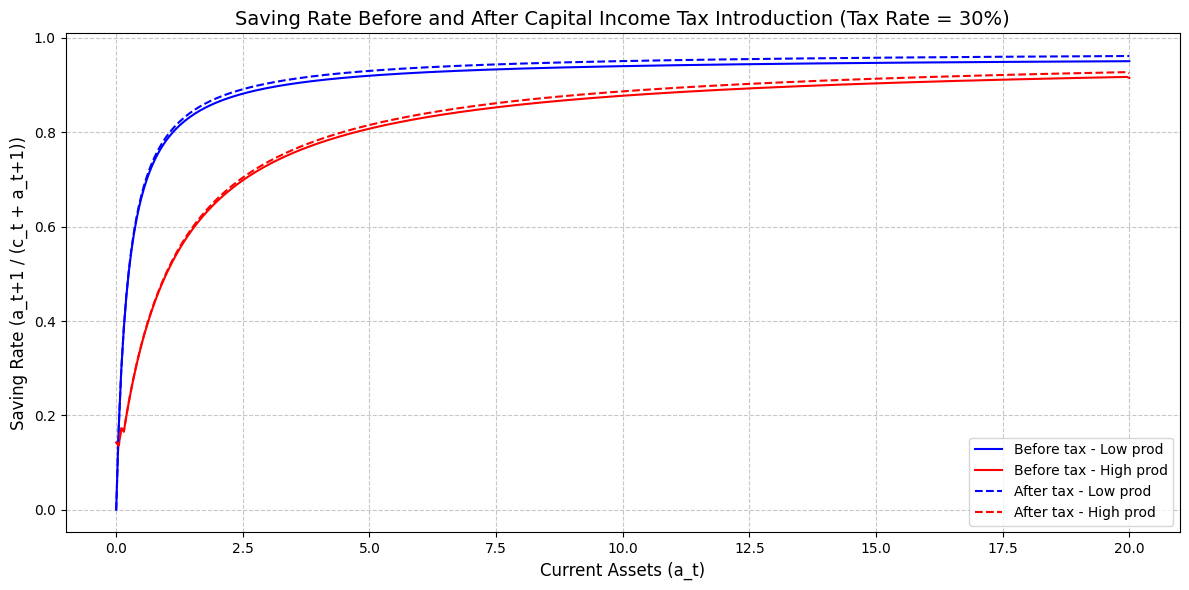

In [12]:
def solve_household(param, r, w, t):
    # Unpacking parameters
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']

    # Create asset grid
    a = np.linspace(a_l, a_u, NA)

    # Initialize arrays
    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))

    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    util = np.full((NA, NA, NH), -10000.0)

    # Calculate utility for all possible asset choices
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                # Budget constraint with capital income tax
                cons = w*h[ih] + (1 + (1-t)*r)*a[ia] - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)

    # Value function iteration
    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))

    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])

        test = np.max(abs(v_new - v))
        v = v_new

    # Asset policy function
    aplus = a[iaplus]

    # Consumption policy function
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1 + (1-t)*r)*a[ia] - aplus[ia, ih]

    return aplus, iaplus, c
# Set parameters
r = 0.04  # interest rate
w = 1  # wage
t = 0.3  # capital income tax rate

param = setPar()

# Solve household problem before tax (t = 0)
decisions_before = solve_household(param, r, w, 0)
aplus_before = decisions_before[0]
c_before = decisions_before[2]

# Solve household problem after tax introduction
decisions_after = solve_household(param, r, w, t)
aplus_after = decisions_after[0]
c_after = decisions_after[2]

# Create grid for plotting
a_l = param['a_l']
a_u = param['a_u']
NA = param['NA']
a = np.linspace(a_l, a_u, NA)

# Create plot
plt.figure(figsize=(12, 6))

# Plot saving rates before tax introduction
plt.plot(a, aplus_before[:, 0]/(c_before[:, 0] + aplus_before[:, 0]), label='Before tax - Low prod', color='blue')
plt.plot(a, aplus_before[:, 1]/(c_before[:, 1] + aplus_before[:, 1]), label='Before tax - High prod', color='red')

# Plot saving rates after tax introduction
plt.plot(a, aplus_after[:, 0]/(c_after[:, 0] + aplus_after[:, 0]), label='After tax - Low prod', color='blue', linestyle='--')
plt.plot(a, aplus_after[:, 1]/(c_after[:, 1] + aplus_after[:, 1]), label='After tax - High prod', color='red', linestyle='--')

# Set labels and title
plt.xlabel('Current Assets (a_t)', fontsize=12)
plt.ylabel('Saving Rate (a_t+1 / (c_t + a_t+1))', fontsize=12)
plt.title('Saving Rate Before and After Capital Income Tax Introduction (Tax Rate = 30%)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

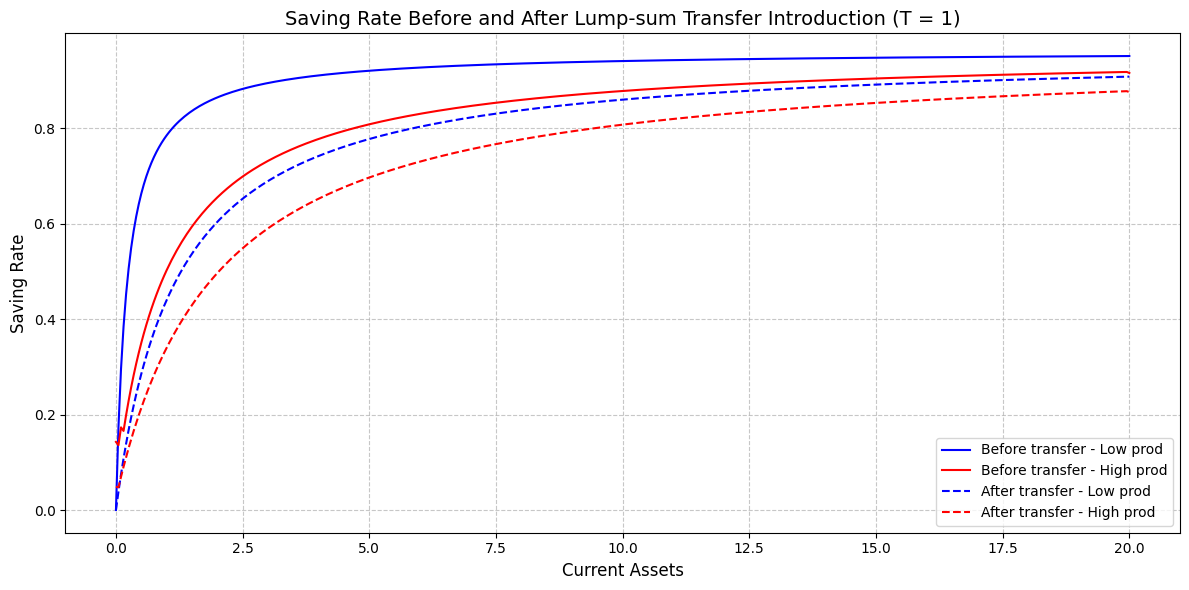

In [13]:
def solve_household(param, r, w, T):
    # Unpacking parameters
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']

    a = np.linspace(a_l, a_u, NA)

    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))

    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    util = np.full((NA, NA, NH), -10000.0)

    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                # Modified budget constraint with lump-sum transfer
                cons = w*h[ih] + (1 + r)*a[ia] + T - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)

    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))

    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])

        test = np.max(abs(v_new - v))
        v = v_new

    aplus = a[iaplus]

    for ia in range(NA):
        for ih in range(NH):
            # Modified consumption calculation
            c[ia, ih] = w*h[ih] + (1 + r)*a[ia] + T - aplus[ia, ih]

    return aplus, iaplus, c

# Set parameters
r = 0.04  # interest rate
w = 1  # wage
T = 1  # lump-sum transfer

param = setPar()

# Solve household problem without transfer (original case)
decisions_before = solve_household(param, r, w, 0)
aplus_before = decisions_before[0]
c_before = decisions_before[2]

# Solve household problem with lump-sum transfer
decisions_after = solve_household(param, r, w, T)
aplus_after = decisions_after[0]
c_after = decisions_after[2]

# Create grid for plotting
a_l = param['a_l']
a_u = param['a_u']
NA = param['NA']
a = np.linspace(a_l, a_u, NA)

# Create plot
plt.figure(figsize=(12, 6))

# Plot saving rates before transfer introduction
plt.plot(a, aplus_before[:, 0]/(c_before[:, 0] + aplus_before[:, 0]), label='Before transfer - Low prod', color='blue')
plt.plot(a, aplus_before[:, 1]/(c_before[:, 1] + aplus_before[:, 1]), label='Before transfer - High prod', color='red')

# Plot saving rates after transfer introduction
plt.plot(a, aplus_after[:, 0]/(c_after[:, 0] + aplus_after[:, 0]), label='After transfer - Low prod', color='blue', linestyle='--')
plt.plot(a, aplus_after[:, 1]/(c_after[:, 1] + aplus_after[:, 1]), label='After transfer - High prod', color='red', linestyle='--')

plt.xlabel('Current Assets', fontsize=12)
plt.ylabel('Saving Rate', fontsize=12)
plt.title('Saving Rate Before and After Lump-sum Transfer Introduction (T = 1)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

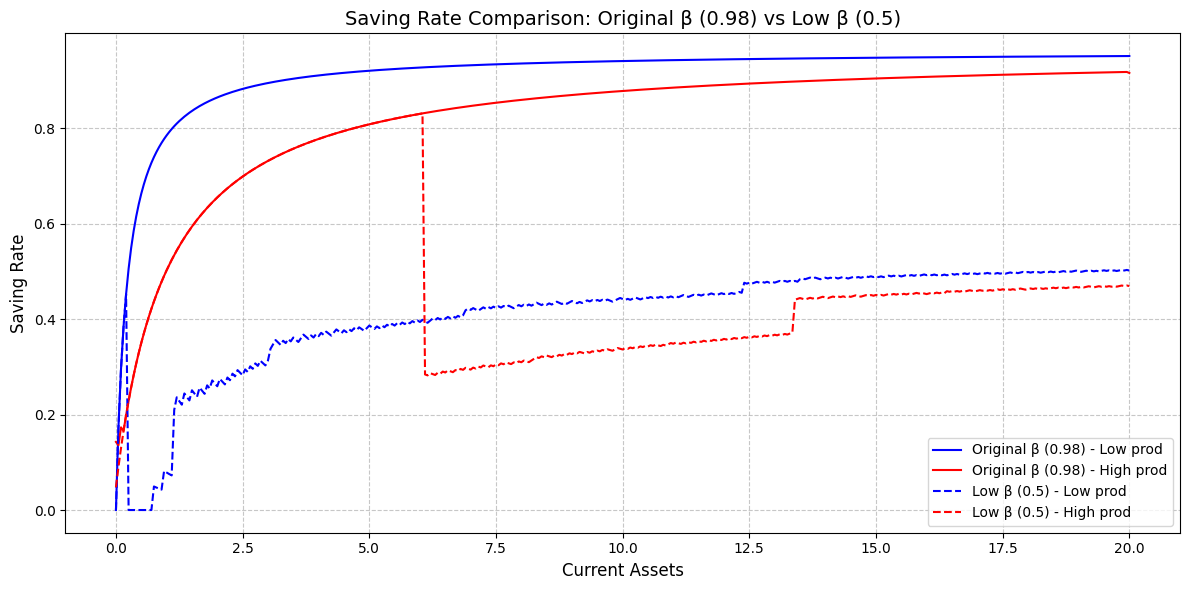

In [14]:
def solve_household(param, r, w):
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']

    a = np.linspace(a_l, a_u, NA)

    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))

    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    util = np.full((NA, NA, NH), -10000.0)

    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w*h[ih] + (1.0 + r)*a[ia] - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)

    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))

    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])

        test = np.max(abs(v_new - v))
        v = v_new

    aplus = a[iaplus]

    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1.0+r)*a[ia] - aplus[ia, ih]

    return aplus, iaplus, c

# Set parameters
r = 0.04  # interest rate
w = 1  # wage

# Original parameters (β = 0.98)
param_original = setPar()

# Parameters with lower β (β = 0.5)
param_low_beta = setPar(beta=0.5)

# Solve household problem with original β
decisions_original = solve_household(param_original, r, w)
aplus_original = decisions_original[0]
c_original = decisions_original[2]

# Solve household problem with low β
decisions_low_beta = solve_household(param_low_beta, r, w)
aplus_low_beta = decisions_low_beta[0]
c_low_beta = decisions_low_beta[2]

# Create grid for plotting
a_l = param_original['a_l']
a_u = param_original['a_u']
NA = param_original['NA']
a = np.linspace(a_l, a_u, NA)

# Create plot
plt.figure(figsize=(12, 6))

# Plot saving rates for original β
plt.plot(a, aplus_original[:, 0]/(c_original[:, 0] + aplus_original[:, 0]), label='Original β (0.98) - Low prod', color='blue')
plt.plot(a, aplus_original[:, 1]/(c_original[:, 1] + aplus_original[:, 1]), label='Original β (0.98) - High prod', color='red')

# Plot saving rates for low β
plt.plot(a, aplus_low_beta[:, 0]/(c_low_beta[:, 0] + aplus_low_beta[:, 0]), label='Low β (0.5) - Low prod', color='blue', linestyle='--')
plt.plot(a, aplus_low_beta[:, 1]/(c_low_beta[:, 1] + aplus_low_beta[:, 1]), label='Low β (0.5) - High prod', color='red', linestyle='--')

plt.xlabel('Current Assets', fontsize=12)
plt.ylabel('Saving Rate', fontsize=12)
plt.title('Saving Rate Comparison: Original β (0.98) vs Low β (0.5)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()